In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # or "3" for GPU 3


/home/shahid/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-07-02 16:35:24.776010: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-02 16:35:24.811308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-02 16:35:24.835250: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-02 16:35:24.842167: E external/local_xla/xla/stream_exe

🚀 Starting DGF feature extraction at 2025-07-02 16:35:37


You are using a model of type swin to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
2025-07-02 16:35:38.342668: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-07-02 16:35:39.628100: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input to reshape is a tensor with 768000 values, but the requested shape has 2304
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['swin.encoder.layers.1.blocks.0.attention.self.relative_position_bias_table', 'swin.encoder.layers.3.blocks.0.intermediate

INFO:tensorflow:Assets written to: ./swin_transformer_dgf/assets


INFO:tensorflow:Assets written to: ./swin_transformer_dgf/assets



➡️ Extracting DGF features for train split...


2025-07-02 16:36:28.933175: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


  [1/2468] data_image/hurricane_harvey/8_9_2017/905960092822003712_0.jpg | Mean: 0.0960
  [2/2468] data_image/california_wildfires/11_10_2017/918008272363368448_0.jpg | Mean: 0.2048
  [3/2468] data_image/hurricane_irma/17_9_2017/909396901254090752_0.jpg | Mean: 0.1048
  [4/2468] data_image/hurricane_maria/24_9_2017/912097936200355841_0.jpg | Mean: 0.1226
  [5/2468] data_image/hurricane_maria/23_10_2017/922610290281402368_1.jpg | Mean: 0.0832
  [6/2468] data_image/california_wildfires/15_10_2017/919585500914208768_0.jpg | Mean: 0.1375
  [7/2468] data_image/hurricane_maria/1_10_2017/914372204787355648_0.jpg | Mean: 0.1367
  [8/2468] data_image/california_wildfires/21_10_2017/921623155835224064_1.jpg | Mean: 0.1276
  [9/2468] data_image/hurricane_harvey/10_9_2017/906792024094986240_0.jpg | Mean: 0.1430
  [10/2468] data_image/hurricane_irma/19_9_2017/910118839081472000_0.jpg | Mean: 0.1354
  [11/2468] data_image/iraq_iran_earthquake/18_11_2017/931898198569996288_0.jpg | Mean: 0.0970
  [12/

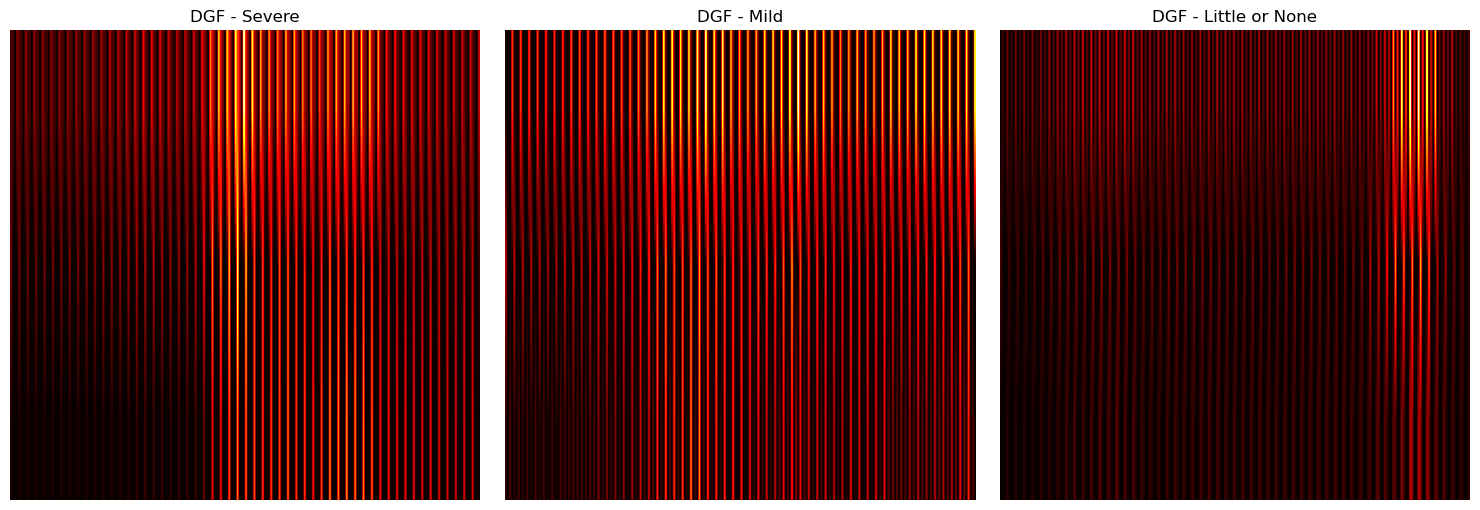

In [2]:
# DGF_Feature_Extraction.ipynb (Notebook 1)

import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from transformers import TFViTForImageClassification, ViTImageProcessor

print(f"\U0001F680 Starting DGF feature extraction at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

image_dir = "/home/shahid/000.Damage Severity/aman/"
model_name = "microsoft/swin-tiny-patch4-window7-224"
model_save_path = "./swin_transformer_dgf"

df_train = pd.read_table(os.path.join(image_dir, "embeddings/task_damage_text_img_train.tsv"))
df_val   = pd.read_table(os.path.join(image_dir, "embeddings/task_damage_text_img_dev.tsv"))
df_test  = pd.read_table(os.path.join(image_dir, "embeddings/task_damage_text_img_test.tsv"))
label_mapping = {"severe_damage": 0, "mild_damage": 1, "little_or_no_damage": 2}
for df in [df_train, df_val, df_test]:
    df["damage_label"] = df["label"].map(label_mapping)

processor = ViTImageProcessor.from_pretrained(model_name)
model = TFViTForImageClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

if not os.path.exists(model_save_path):
    model.save(model_save_path)

def load_image(image_path):
    full_path = os.path.join(image_dir, image_path)
    if not os.path.exists(full_path):
        return None, None
    img = cv2.imread(full_path)
    if img is None:
        return None, None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    inputs = processor(images=img_resized, return_tensors="tf")
    return img_resized, inputs["pixel_values"]

def compute_dgf(image, img_tensor):
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        score = preds.logits[0, 0]
    grads = tape.gradient(score, img_tensor)
    cam = np.mean(grads.numpy()[0], axis=-1)
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam / (np.max(cam) + 1e-6)
    features = [np.mean(cam), np.max(cam), np.std(cam)]
    return np.nan_to_num(features), cam

def extract_dgf_features(df, split):
    features = []
    print(f"\n\u27a1\ufe0f Extracting DGF features for {split} split...")
    for idx, row in df.iterrows():
        img, img_tensor = load_image(row['image'])
        if img is None or img_tensor is None:
            continue
        feat, _ = compute_dgf(img, img_tensor)
        features.append(feat)
        print(f"  [{idx+1}/{len(df)}] {row['image']} | Mean: {feat[0]:.4f}")
    features = np.array(features)
    np.save(f"{split}_dgf_features.npy", features)
    print(f"\u2705 Saved {features.shape[0]} features to {split}_dgf_features.npy")

extract_dgf_features(df_train, "train")
extract_dgf_features(df_val, "val")
extract_dgf_features(df_test, "test")

# Visualization
print("\n\U0001F5BC Generating DGF visualizations...")
class_names = ["Severe", "Mild", "Little or None"]
class_images = {}
for label in [0, 1, 2]:
    rows = df_test[df_test["damage_label"] == label]
    if not rows.empty:
        class_images[label] = rows.iloc[0]["image"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, label in enumerate([0, 1, 2]):
    img, img_tensor = load_image(class_images[label])
    _, dgf_map = compute_dgf(img, img_tensor)
    axes[i].imshow(dgf_map, cmap='hot')
    axes[i].set_title(f"DGF - {class_names[i]}")
    axes[i].axis('off')
plt.tight_layout()
plt.savefig("dgf_feature_visualizations_swin.png")
print("\u2705 Visualization saved as dgf_feature_visualizations_swin.png")
